In [1]:
!pip install fsspec
!pip install sklearn

     |████████████████████████████████| 122kB 2.9MB/s eta 0:00:01
     |████████████████████████████████| 22.3MB 34.4MB/s eta 0:00:01    |████████▍                       | 5.8MB 34.4MB/s eta 0:00:01
     |████████████████████████████████| 307kB 71.6MB/s eta 0:00:01
     |████████████████████████████████| 28.5MB 1.1MB/s  eta 0:00:01     |██████████████████▌             | 16.5MB 61.9MB/s eta 0:00:01
  Stored in directory: /home/labuser/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [3]:
!pip install seaborn

     |████████████████████████████████| 286kB 18.8MB/s eta 0:00:01


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [5]:
from hdfs import InsecureClient
client = InsecureClient('http://datalake:50070')

client.status("/")
with client.read('/shared/havells_trail/raw/data_Pipeline.csv', encoding = 'utf-8') as reader:
    df = pd.read_csv(reader, sep=",")

In [6]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,S
1,1,1,1,38.0,1,0,71.2833,C
2,1,3,1,26.0,0,0,7.9250,S
3,1,1,1,35.0,1,0,53.1000,S
4,0,3,0,35.0,0,0,8.0500,S


In [7]:
## Checking the Info

In [12]:
df.info()   #All the columns seems to be of correct datatype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(5), object(1)
memory usage: 55.8+ KB


In [9]:
## Describing the Data

In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Sex,891.0,0.352413,0.477990,0.00,0.0000,0.0000,1.0,1.0000
Age,891.0,29.361582,13.019697,0.42,22.0000,28.0000,35.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [13]:
## checking the null values

In [18]:
a=df.isna().sum()/len(df)*100

In [19]:
a.rename_axis('Columns').reset_index(name='Perecentage of Null Values')

,Columns,Perecentage of Null Values
0,Survived,0.0
1,Pclass,0.0
2,Sex,0.0
3,Age,0.0
4,SibSp,0.0
5,Parch,0.0
6,Fare,0.0
7,Embarked,0.0


In [17]:
## so there are no null values in the data and we can proceed forward

## Univariate Analysis

In [22]:
num_col=df[df.dtypes[df.dtypes!='object'].index]
num_col.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,0,22.0,1,0,7.2500
1,1,1,1,38.0,1,0,71.2833
2,1,3,1,26.0,0,0,7.9250
3,1,1,1,35.0,1,0,53.1000
4,0,3,0,35.0,0,0,8.0500


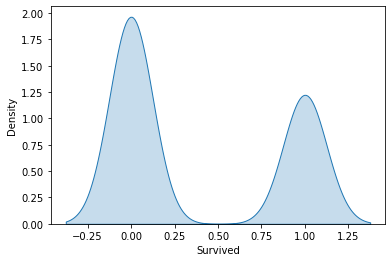

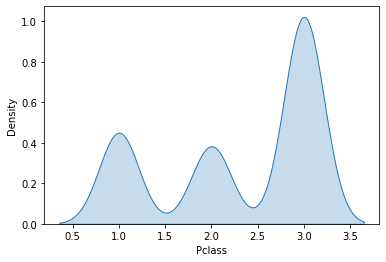

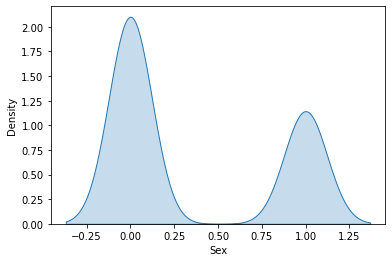

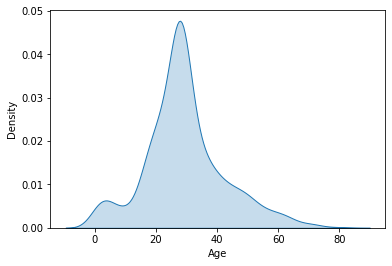

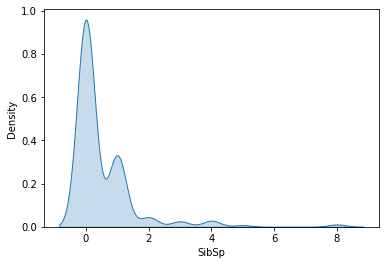

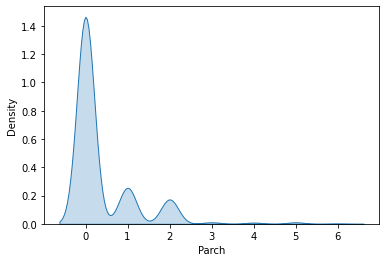

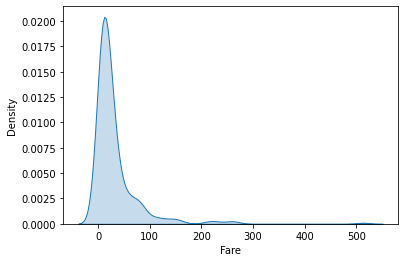

In [23]:
for i in num_col.columns:
    sns.kdeplot(num_col[i],shade=True)
    plt.show()

## Bivariate Analysis

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


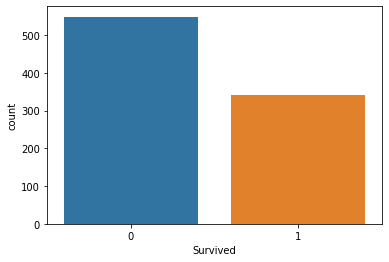

In [24]:
sns.countplot(df['Survived'])
plt.show()

In [25]:
import scipy.stats as stats

## Doing Statistical tests

In [26]:
df0=df[df['Survived']==0]
df1=df[df['Survived']==1]

In [27]:
for i in df.columns:
    tstats,pvalue=stats.ttest_ind(df0[i],df1[i])
    if pvalue>0.05:
        print('Pvalue for the column is',i,pvalue)

Pvalue for the column is Age 0.0527606884758555
Pvalue for the column is SibSp 0.2922439286982937


TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [29]:
# So we can exclude these columns Especially SibSp

## Checking the Correlation

In [31]:
heat=df.corr().loc['Survived'].sort_values(ascending=False)

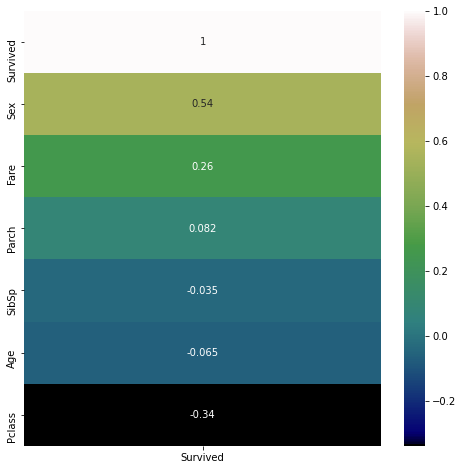

In [33]:
plt.figure(figsize=(8,8))
sns.heatmap(heat.to_frame(),annot=True,cmap='gist_earth')
plt.show()

In [35]:
## Scaling

In [38]:
X=df.drop(['Survived','SibSp',"Embarked"],axis=1)
y=df['Survived']

In [40]:
sc=StandardScaler()
num_sc=sc.fit_transform(X)
num_sc=pd.DataFrame(num_sc,columns=X.columns)
num_sc.head()

,Pclass,Sex,Age,Parch,Fare
0,0.827377,-0.737695,-0.565736,-0.473674,-0.502445
1,-1.566107,1.355574,0.663861,-0.473674,0.786845
2,0.827377,1.355574,-0.258337,-0.473674,-0.488854
3,-1.566107,1.355574,0.433312,-0.473674,0.420730
4,0.827377,-0.737695,0.433312,-0.473674,-0.486337


In [49]:
x1=pd.get_dummies(df['Embarked'])

In [53]:
X1=pd.concat([num_sc,x1],axis=1)
X1.head()

,Pclass,Sex,Age,Parch,Fare,C,Q,S
0,0.827377,-0.737695,-0.565736,-0.473674,-0.502445,0,0,1
1,-1.566107,1.355574,0.663861,-0.473674,0.786845,1,0,0
2,0.827377,1.355574,-0.258337,-0.473674,-0.488854,0,0,1
3,-1.566107,1.355574,0.433312,-0.473674,0.420730,0,0,1
4,0.827377,-0.737695,0.433312,-0.473674,-0.486337,0,0,1


## Splitting data into train_test_split

In [54]:
xtrain,xtest,ytrain,ytest=train_test_split(X1,y,test_size=0.3,random_state=48,stratify=y)

In [55]:
log_reg=LogisticRegression()
log_reg.fit(xtrain,ytrain)

LogisticRegression()

In [56]:
from sklearn.metrics import accuracy_score

In [57]:
ypred_test=log_reg.predict(xtest)
test_accuracy=accuracy_score(ytest,ypred_test)
test_accuracy

0.7910447761194029

In [58]:
ypred_train=log_reg.predict(xtrain)
train_accuracy=accuracy_score(ytrain,ypred_train)
train_accuracy

0.8009630818619583

## RandomForest Classifier

In [60]:
from sklearn.ensemble import RandomForestClassifier

In [83]:
rf=RandomForestClassifier(n_estimators=110,criterion='gini',random_state=48)
rf.fit(xtrain,ytrain)

RandomForestClassifier(n_estimators=110, random_state=48)

In [84]:
ypred_test=rf.predict(xtest)
test_accuracy=accuracy_score(ytest,ypred_test)
test_accuracy

0.8022388059701493

In [85]:
ypred_train=rf.predict(xtrain)
train_accuracy=accuracy_score(ytrain,ypred_train)
train_accuracy

0.9839486356340289

In [79]:
## Case of overfitting

## KNN

In [86]:
knn=KNeighborsClassifier()
knn.fit(xtrain,ytrain)

KNeighborsClassifier()

In [87]:
ypred_test=knn.predict(xtest)
test_accuracy=accuracy_score(ytest,ypred_test)
test_accuracy

0.8097014925373134

In [89]:
ypred_train=knn.predict(xtrain)
train_accuracy=accuracy_score(ytrain,ypred_train)
train_accuracy

0.8491171749598716